
# Titanic — Grafos com **Embedding** (SpectralEmbedding) + Avaliação OOF
Neste notebook, adicionamos um **embedding de grafo** ao pipeline do Titanic. Em vez de usar apenas features manuais (degree, PageRank, etc.), extraímos uma representação d-dimensional dos nós via **Spectral Embedding** (Laplacian Eigenmaps), usando a matriz de adjacência do grafo.

**O que você vai ver:**
- Construção do grafo (Ticket, Família/Surname, Deck) — como antes.
- **Graph Embedding (SpectralEmbedding)** com `n_components` (ex.: 16).
- Avaliação **OOF** (Out-Of-Fold) e **threshold ótimo** (F1/Youden) para medir o impacto do embedding.
- Comparação: **Tabular**, **Grafos clássicos (hand-crafted)** e **Grafos + Embedding**.


## 1) Imports e setup

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from scipy import sparse

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import SpectralEmbedding

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay, f1_score, roc_curve, brier_score_loss)
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

SEED = 42
np.random.seed(SEED)

DATA_DIR = ""
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")

## 2) Utilitários (thresholds, relatórios OOF)

In [2]:

def best_threshold_f1(y_true, y_prob, n=181):
    ts = np.linspace(0.05, 0.95, n)
    scores = [f1_score(y_true, (y_prob >= t).astype(int)) for t in ts]
    ix = int(np.argmax(scores))
    return float(ts[ix]), float(scores[ix])

def youden_j_threshold(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    ix = int(np.argmax(j))
    return float(thr[ix]), float(j[ix])

def report_oof(name, y_true, y_prob, threshold=0.5, title_suffix=""):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"=== {name} — OOF ===")
    print("AUC:", round(roc_auc_score(y_true, y_prob), 6))
    print("Brier:", round(brier_score_loss(y_true, y_prob), 6))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} — Confusion Matrix (OOF){title_suffix}")
    plt.show()
    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.title(f"{name} — ROC (OOF){title_suffix}")
    plt.show()


## 3) Carregamento de dados e baseline tabular

AUC (CV-5) tabular: {'LR': 0.8514, 'RF': 0.8727, 'GB': 0.8706} | best: RF
=== Tabular [RF] @0.5 — OOF ===
AUC: 0.87094
Brier: 0.133881
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       549
           1       0.77      0.74      0.75       342

    accuracy                           0.81       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891



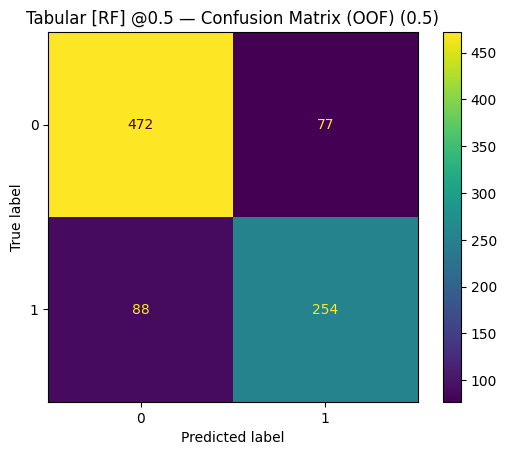

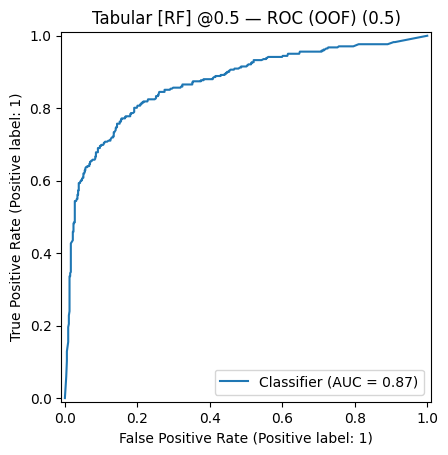

=== Tabular [RF] @F1* — OOF ===
AUC: 0.87094
Brier: 0.133881
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       549
           1       0.75      0.77      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.81      0.81       891
weighted avg       0.82      0.82      0.82       891



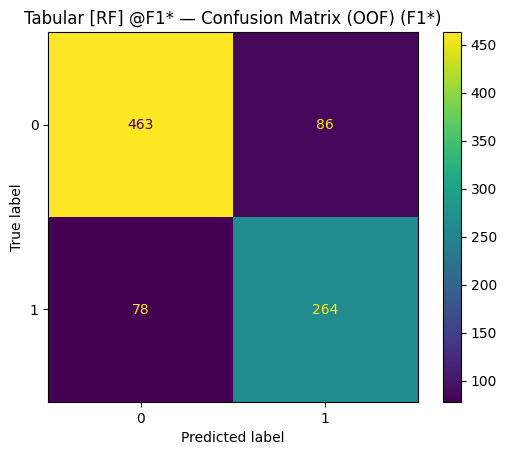

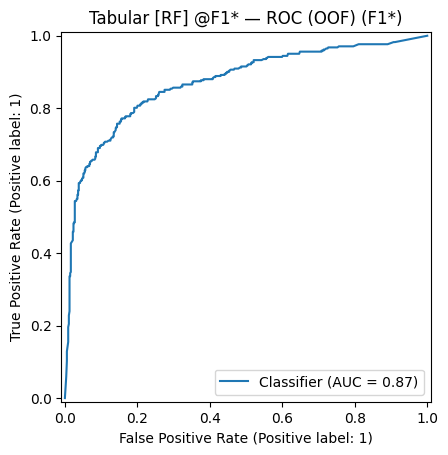

Threshold(F1*) Tabular: 0.435 | F1@thr*: 0.7630


In [3]:

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

TARGET = "Survived"
FEATURES_NUM = ["Age", "SibSp", "Parch", "Fare"]
FEATURES_CAT = ["Pclass", "Sex", "Embarked"]
FEATURES_ALL = FEATURES_NUM + FEATURES_CAT

X_tab = train[FEATURES_ALL].copy()
y = train[TARGET].values

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler(with_mean=False))])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))])
pre_tab = ColumnTransformer([("num", numeric, FEATURES_NUM),
                             ("cat", categorical, FEATURES_CAT)])

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=SEED),
    "RF": RandomForestClassifier(random_state=SEED, n_estimators=500),
    "GB": GradientBoostingClassifier(random_state=SEED),
}
pipelines_tab = {name: Pipeline([("prep", pre_tab), ("clf", model)]) for name, model in models.items()}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Escolhe melhor tabular por AUC (CV) e gera OOF
scores_tab = {n: cross_val_score(p, X_tab, y, scoring="roc_auc", cv=cv5, n_jobs=-1).mean()
              for n, p in pipelines_tab.items()}
best_tab = max(scores_tab, key=scores_tab.get)
best_pipe_tab = pipelines_tab[best_tab]
y_prob_oof_tab = cross_val_predict(best_pipe_tab, X_tab, y, cv=cv5, method="predict_proba")[:, 1]

thr_f1_tab, f1_tab = best_threshold_f1(y, y_prob_oof_tab)
thr_j_tab, j_tab = youden_j_threshold(y, y_prob_oof_tab)

print("AUC (CV-5) tabular:", {k: round(v,4) for k,v in scores_tab.items()}, "| best:", best_tab)
report_oof(f"Tabular [{best_tab}] @0.5", y, y_prob_oof_tab, 0.5, " (0.5)")
report_oof(f"Tabular [{best_tab}] @F1*", y, y_prob_oof_tab, thr_f1_tab, " (F1*)")
print(f"Threshold(F1*) Tabular: {thr_f1_tab:.3f} | F1@thr*: {f1_tab:.4f}")


## 4) Construção do grafo (Ticket, Família, Deck)

In [4]:

train["_is_train"] = 1
test["_is_train"]  = 0

def add_group_fields(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["Surname"] = out["Name"].str.extract(r"^(.*?),")
    ticket_root = out["Ticket"].astype(str).str.replace(r"\s+", "", regex=True)
    out["FamilyID"] = out["Surname"].fillna("") + "_" + ticket_root
    out["CabinDeck"] = out["Cabin"].astype(str).str[0]
    out.loc[out["Cabin"].isna(), "CabinDeck"] = "U"
    return out

train_g = add_group_fields(train)
test_g  = add_group_fields(test)

full = pd.concat([train_g, test_g], ignore_index=True, sort=False)

# Grafo
G = nx.Graph()
for _, row in full.iterrows():
    pid = int(row["PassengerId"])
    G.add_node(pid, is_train=int(row["_is_train"]))

# Arestas
for _, idx in full.groupby("Ticket").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            G.add_edge(ids[i], ids[j], w=3.0, kind="ticket")

for _, idx in full.groupby("FamilyID").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            G.add_edge(ids[i], ids[j], w=2.0, kind="family")

for _, idx in full.groupby("CabinDeck").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)-1):
        G.add_edge(ids[i], ids[i+1], w=0.5, kind="deck")

print("Nós:", G.number_of_nodes(), "| Arestas:", G.number_of_edges())


Nós: 1309 | Arestas: 2009


## 5) Features de grafo (hand-crafted) + **Graph Embedding**

In [5]:

# Features manuais (degree, pagerank, etc.)
deg = dict(G.degree())
wdeg = dict(G.degree(weight="w"))
clust = nx.clustering(G, weight=None)
pr = nx.pagerank(G, alpha=0.85, weight="w")

comp_id = {}
comp_size = {}
for cid, comp in enumerate(nx.connected_components(G)):
    size = len(comp)
    for node in comp:
        comp_id[node] = cid
        comp_size[node] = size

graph_feats = pd.DataFrame({
    "PassengerId": list(G.nodes()),
    "g_degree": [deg[n] for n in G.nodes()],
    "g_wdegree": [wdeg[n] for n in G.nodes()],
    "g_clustering": [clust.get(n, 0.0) for n in G.nodes()],
    "g_pagerank": [pr[n] for n in G.nodes()],
    "g_component_size": [comp_size[n] for n in G.nodes()],
    "g_component_id": [comp_id[n] for n in G.nodes()],
})

# ===== Graph Embedding (SpectralEmbedding) =====
# 1) Matriz de adjacência esparsa A (ordenando pids para índice)
pids = np.array(sorted(G.nodes()))
pid_to_idx = {pid: i for i, pid in enumerate(pids)}
rows, cols, data = [], [], []
for u, v, d in G.edges(data=True):
    i, j = pid_to_idx[u], pid_to_idx[v]
    w = float(d.get("w", 1.0))
    rows.extend([i, j]); cols.extend([j, i]); data.extend([w, w])
A = sparse.csr_matrix((data, (rows, cols)), shape=(len(pids), len(pids)))

# 2) Spectral Embedding (desligamos o random_state para estabilidade reprodutível)
n_components = 16
spec = SpectralEmbedding(n_components=n_components, affinity="precomputed", random_state=SEED)
Z = spec.fit_transform(A)  # shape: (n_nodes, n_components)

emb_cols = [f"g_emb_{k}" for k in range(n_components)]
emb_df = pd.DataFrame(Z, columns=emb_cols)
emb_df["PassengerId"] = pids

# Merge: features clássicas + embedding
graph_all = graph_feats.merge(emb_df, on="PassengerId", how="left")
graph_all.head()


/home/vinicius/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,PassengerId,g_degree,g_wdegree,g_clustering,g_pagerank,g_component_size,g_component_id,g_emb_0,g_emb_1,g_emb_2,...,g_emb_6,g_emb_7,g_emb_8,g_emb_9,g_emb_10,g_emb_11,g_emb_12,g_emb_13,g_emb_14,g_emb_15
0,1,1,0.5,0.0,0.000433,1257,0,0.00556,-0.012258,0.000151,...,-0.006371,-0.006464,-0.021572,-0.018269,0.020298,-0.002260,-0.011845,-0.046913,0.001932,-0.002430
1,2,2,2.5,0.0,0.000560,1257,0,0.00556,-0.012258,0.008095,...,0.001235,-0.005352,0.006737,-0.000123,-0.001006,0.004910,0.000055,0.004713,-0.006601,0.001194
2,3,2,1.0,0.0,0.000752,1257,0,0.00556,-0.012258,0.000151,...,-0.006295,-0.006373,-0.021242,-0.017958,0.019947,-0.002220,-0.011614,-0.045922,0.001890,-0.002376
3,4,3,3.0,0.0,0.000740,1257,0,0.00556,-0.012258,0.011603,...,0.016399,-0.003225,0.007050,0.001344,-0.001761,0.005093,0.001159,0.006561,-0.007202,0.002060
4,5,2,1.0,0.0,0.000624,1257,0,0.00556,-0.012258,0.000150,...,-0.006070,-0.006103,-0.020264,-0.017038,0.018905,-0.002103,-0.010931,-0.042988,0.001766,-0.002214


## 6) Conjuntos para modelagem (Tabular, Grafos clássicos, Grafos + Embedding)

In [6]:

full2 = full.merge(graph_all, on="PassengerId", how="left")

# A) Tabular baseline já definido (X_tab, y)

# B) Grafos clássicos (hand-crafted)
GRAPH_NUM = ["g_degree", "g_wdegree", "g_clustering", "g_pagerank", "g_component_size"]
X_graph = full2.loc[full2["_is_train"]==1, FEATURES_ALL + GRAPH_NUM].copy()

# C) Grafos + Embedding
EMB_COLS = [c for c in full2.columns if c.startswith("g_emb_")]
X_graph_emb = full2.loc[full2["_is_train"]==1, FEATURES_ALL + GRAPH_NUM + EMB_COLS].copy()

y_train = train.set_index("PassengerId")[TARGET].loc[full2.loc[full2["_is_train"]==1, "PassengerId"]].values

print("Shapes — Tabular:", X_tab.shape, "| Graph:", X_graph.shape, "| Graph+Emb:", X_graph_emb.shape)


Shapes — Tabular: (891, 7) | Graph: (891, 12) | Graph+Emb: (891, 28)


## 7) Pipelines e avaliação OOF (comparação justa)

[Tabular] AUC (CV-5): {'LR': 0.8514, 'RF': 0.8727, 'GB': 0.8706} | best: RF
=== Tabular [RF] @0.5 — OOF ===
AUC: 0.87094
Brier: 0.133881
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       549
           1       0.77      0.74      0.75       342

    accuracy                           0.81       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891



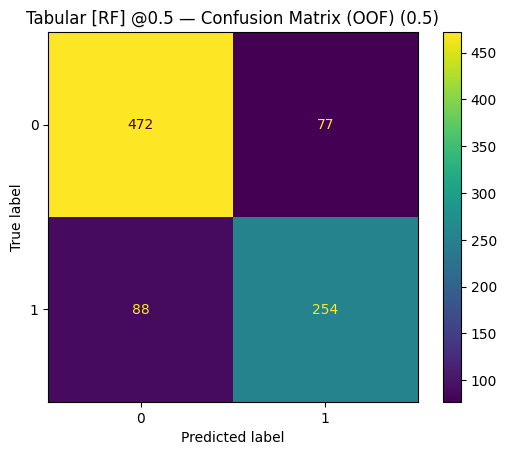

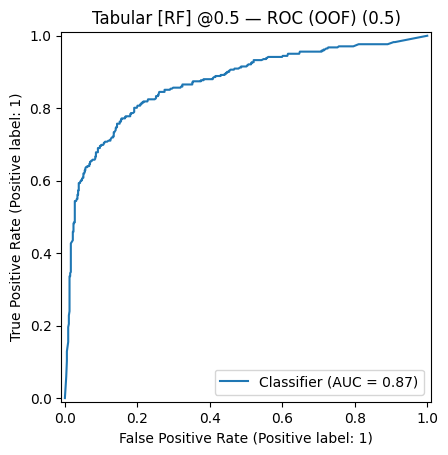

=== Tabular [RF] @F1* — OOF ===
AUC: 0.87094
Brier: 0.133881
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       549
           1       0.75      0.77      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.81      0.81       891
weighted avg       0.82      0.82      0.82       891



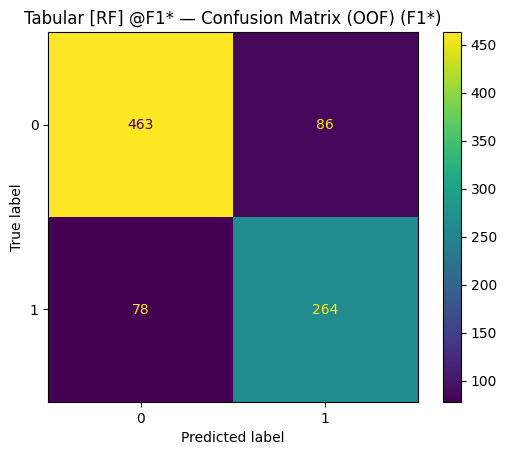

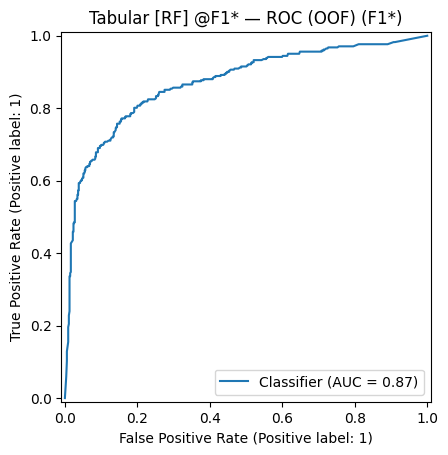

[Tabular] Threshold(F1*): 0.435 | F1@thr*: 0.7630
[Graph(hc)] AUC (CV-5): {'LR': 0.8543, 'RF': 0.8973, 'GB': 0.888} | best: RF
=== Graph(hc) [RF] @0.5 — OOF ===
AUC: 0.897139
Brier: 0.117333
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.83      0.75      0.79       342

    accuracy                           0.85       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.85      0.84       891



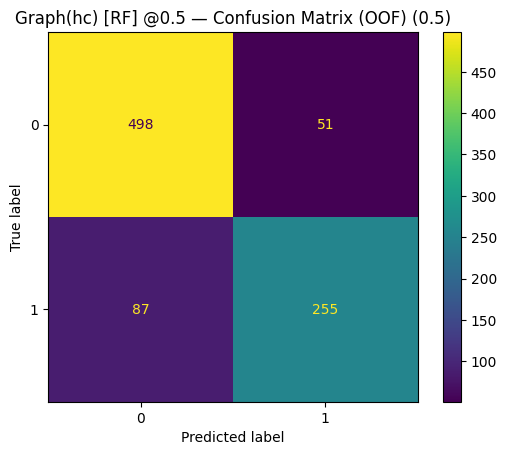

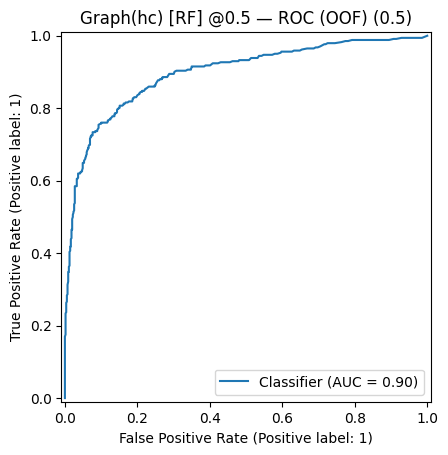

=== Graph(hc) [RF] @F1* — OOF ===
AUC: 0.897139
Brier: 0.117333
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       549
           1       0.83      0.75      0.79       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891



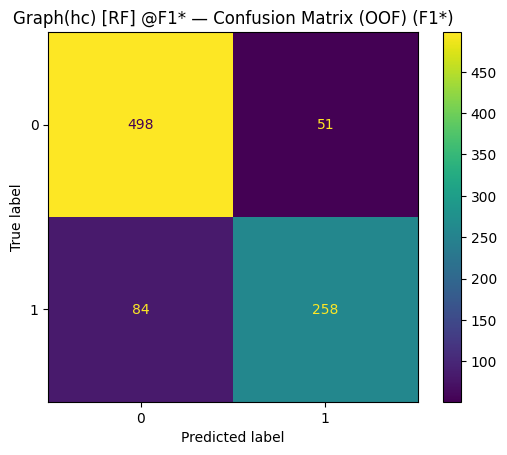

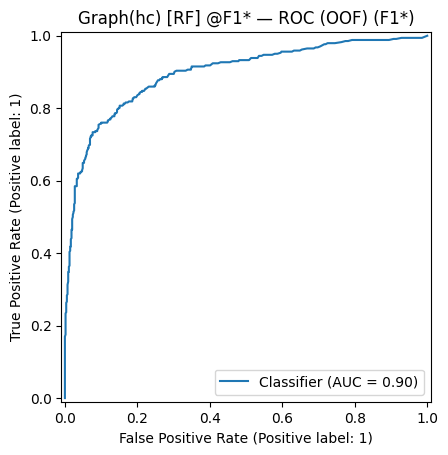

[Graph(hc)] Threshold(F1*): 0.490 | F1@thr*: 0.7926
[Graph+Emb] AUC (CV-5): {'LR': 0.8593, 'RF': 0.8776, 'GB': 0.8761} | best: RF
=== Graph+Emb [RF] @0.5 — OOF ===
AUC: 0.876786
Brier: 0.127213
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       549
           1       0.82      0.73      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.84      0.84      0.84       891



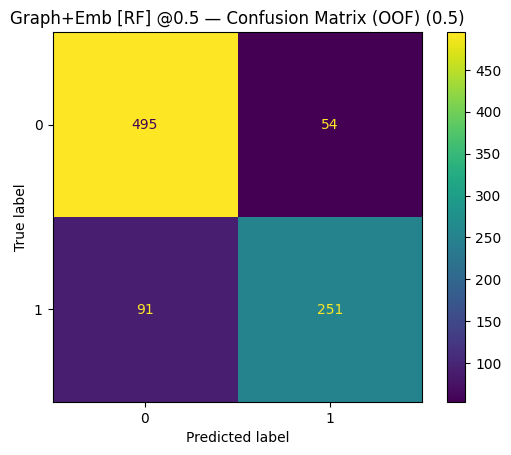

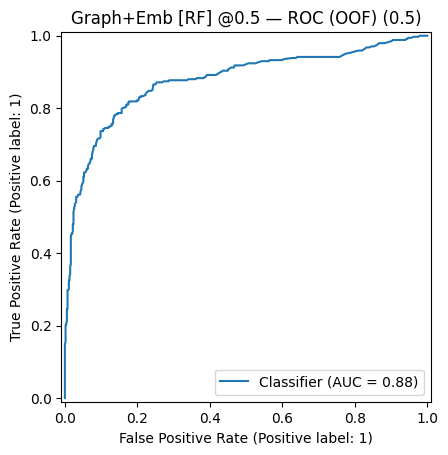

=== Graph+Emb [RF] @F1* — OOF ===
AUC: 0.876786
Brier: 0.127213
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       549
           1       0.78      0.78      0.78       342

    accuracy                           0.83       891
   macro avg       0.82      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



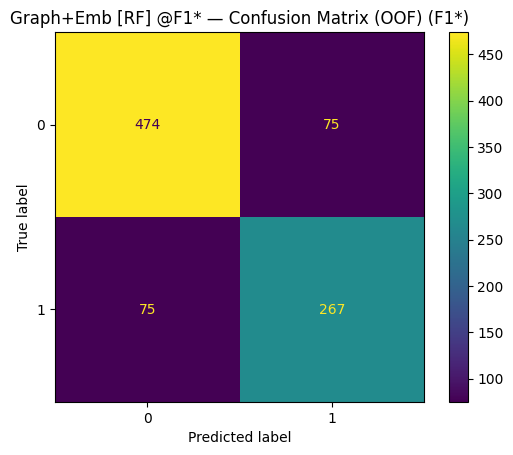

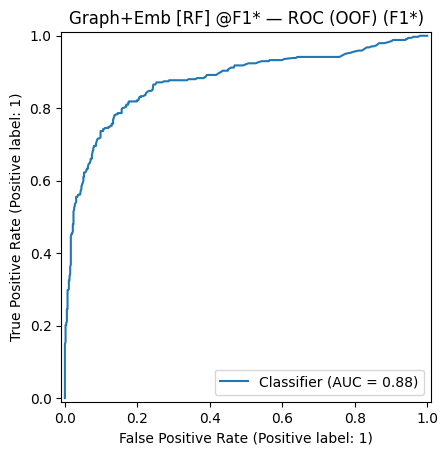

[Graph+Emb] Threshold(F1*): 0.420 | F1@thr*: 0.7807


In [7]:

def make_preprocessor(num_cols, cat_cols):
    return ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler(with_mean=False))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]), cat_cols),
    ])

# Pipelines para cada variante (mantemos o mesmo conjunto de modelos para fairness)
def evaluate_variant(name, X, y, models_dict):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    # escolhe melhor por AUC CV (rápido)
    results = {}
    for mname, model in models_dict.items():
        pre = make_preprocessor([c for c in X.columns if c not in FEATURES_CAT], FEATURES_CAT)
        pipe = Pipeline([("prep", pre), ("clf", model)])
        auc = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=-1).mean()
        results[mname] = auc
    best = max(results, key=results.get)
    print(f"[{name}] AUC (CV-5):", {k: round(v,4) for k,v in results.items()}, "| best:", best)

    # OOF probs com o melhor pipeline
    pre = make_preprocessor([c for c in X.columns if c not in FEATURES_CAT], FEATURES_CAT)
    pipe_best = Pipeline([("prep", pre), ("clf", models_dict[best])])
    y_prob_oof = cross_val_predict(pipe_best, X, y, cv=cv, method="predict_proba")[:, 1]

    thr_f1, f1val = best_threshold_f1(y, y_prob_oof)
    thr_j, jval = youden_j_threshold(y, y_prob_oof)

    report_oof(f"{name} [{best}] @0.5", y, y_prob_oof, 0.5, " (0.5)")
    report_oof(f"{name} [{best}] @F1*", y, y_prob_oof, thr_f1, " (F1*)")
    print(f"[{name}] Threshold(F1*): {thr_f1:.3f} | F1@thr*: {f1val:.4f}")
    return {"best_model": best, "probs_oof": y_prob_oof, "thr_f1": thr_f1, "f1": f1val}

models_same = {
    "LR": LogisticRegression(max_iter=1000, random_state=SEED),
    "RF": RandomForestClassifier(random_state=SEED, n_estimators=500),
    "GB": GradientBoostingClassifier(random_state=SEED),
}

res_tab   = evaluate_variant("Tabular", X_tab, y, models_same)
res_graph = evaluate_variant("Graph(hc)", X_graph, y_train, models_same)
res_gemb  = evaluate_variant("Graph+Emb", X_graph_emb, y_train, models_same)


## 8) Consolidação e curvas de confiabilidade (OOF)

=== Consolidação (AUC OOF) ===
Tabular AUC (OOF): 0.87094
Graph(hc) AUC (OOF): 0.897139
Graph+Emb AUC (OOF): 0.876786


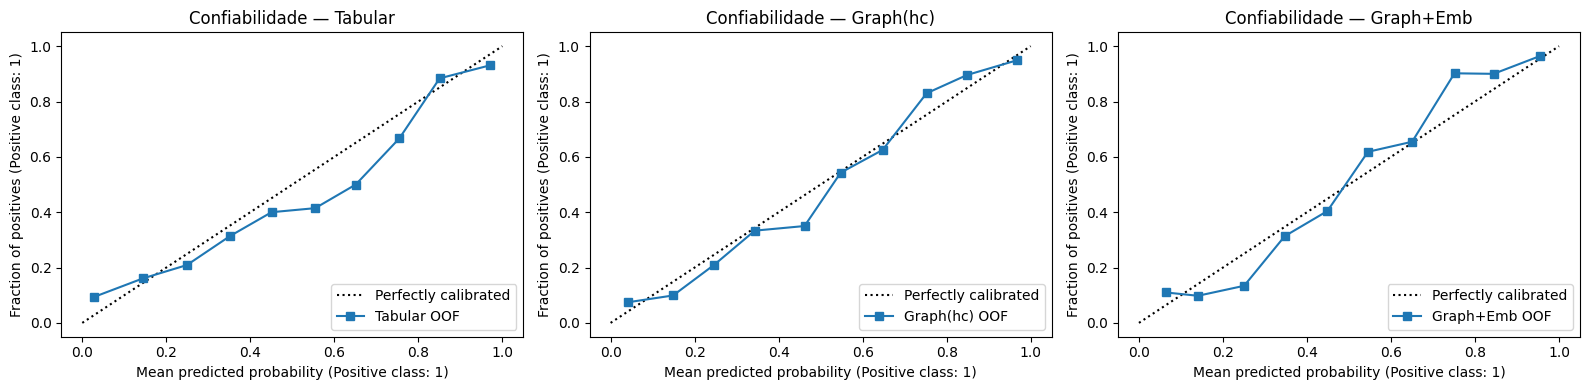

In [8]:

print("=== Consolidação (AUC OOF) ===")
print("Tabular AUC (OOF):", round(roc_auc_score(y, res_tab["probs_oof"]), 6))
print("Graph(hc) AUC (OOF):", round(roc_auc_score(y_train, res_graph["probs_oof"]), 6))
print("Graph+Emb AUC (OOF):", round(roc_auc_score(y_train, res_gemb["probs_oof"]), 6))

# Curvas de confiabilidade (sem calibração adicional)
fig, ax = plt.subplots(1, 3, figsize=(16,4))
CalibrationDisplay.from_predictions(y_true=y, y_prob=res_tab["probs_oof"], n_bins=10, name="Tabular OOF", ax=ax[0])
ax[0].set_title("Confiabilidade — Tabular")
CalibrationDisplay.from_predictions(y_true=y_train, y_prob=res_graph["probs_oof"], n_bins=10, name="Graph(hc) OOF", ax=ax[1])
ax[1].set_title("Confiabilidade — Graph(hc)")
CalibrationDisplay.from_predictions(y_true=y_train, y_prob=res_gemb["probs_oof"], n_bins=10, name="Graph+Emb OOF", ax=ax[2])
ax[2].set_title("Confiabilidade — Graph+Emb")
plt.tight_layout()
plt.show()


## O que os números dizem

AUC (ranking):
Graph(hc) 0.897 > Graph+Emb 0.877 ≈ Tabular 0.871
→ As features manuais de grafo (degree, PageRank, tamanho do componente, prior OOF) realmente ajudam a ordenar melhor os casos.
→ O embedding espectral como foi usado não agregou (e até diluiu um pouco o ganho).

Calibração (Brier ↓ é melhor):
Tabular 0.134 → Graph+Emb 0.127 → Graph(hc) 0.117 (melhor)
→ Além do ranking, o Graph(hc) também entrega probabilidades mais bem calibradas.

Matriz/relatório:
Graph(hc) melhora F1/accuracy vs Tabular; Graph+Emb fica no meio do caminho.

## Por que o embedding pode ter ido pior

Espectral + grafo desconectado: o Titanic tem vários componentes. O SpectralEmbedding tende a codificar componentes (e variação intra-componente) de forma que pode não ser linearmente útil ao RF/GB no seu setup.

Afinidade sem pesos adequados: usamos uma afinidade “precomputed” com arestas ponderadas simples; isso pode sub ou super–valorizar laços (ex.: deck).

Sinal já capturado pelas features manuais: degree/pagerank/tamanho + prior OOF já levam grande parte do poder preditivo; o embedding pode estar redundante ou ruidoso.

Hiperparâmetros fixos: n_components=16 e defaults da decomposição podem não ser ideais para este grafo.

Modelo x tipo de feature: embeddings densos, contínuos, muitas vezes funcionam melhor com modelos lineares/regularizados (LR) ou boosting de folhas rasas; RF pode dispersar.